In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde, chi2
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

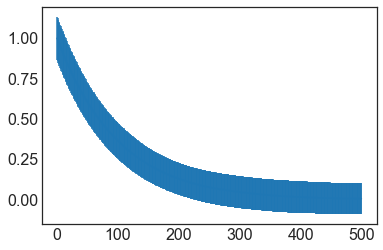

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

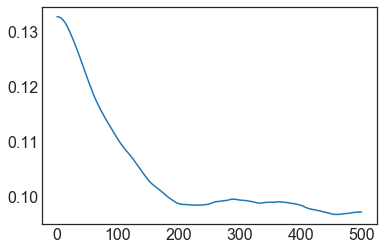

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1],
                              out.chisqr])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out2.covar[0,1],
                            out2.chisqr])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    decay:      99.3941865 +/- 0.96000784 (0.97%) (init = 100)
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    decay:      101.268683 +/- 1.05611196 (1.04%) (init = 100)
    amplitude:  0.79842691 +/- 0.0066952

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.40241501
    reduced chi-square = 8.0806e-04
    Akaike info crit   = -3558.43973
    Bayesian info crit = -3550.01051
[[Variables]]
    decay:      102.603215 +/- 0.96425099 (0.94%) (init = 100)
    amplitude:  0.84285201 +/- 0.00556481 (0.66%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 33.8773073
    reduced chi-square = 0.06802672
    Akaike info crit   = -1341.93135
    Bayesian info crit = -1333.50214
[[Variables]]
    decay:      104.564742 +/- 0.98497724 (0.94%) (init = 100)
    amplitude:  0.83278810 +/- 0.00630922 (0.76%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 84.2344506
    reduced chi-square = 0.16914548
    Akaike info crit   = -886.502054
    Bayesian info crit = -878.072838
[[Variables]]
    decay:      100.397874 +/- 0.99728756 (0.99%) (init = 100)
    amplitude:  1.27250050 +/- 0.01016278 (0.80%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.722

***** Iteration  29  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.50323777
    reduced chi-square = 0.00101052
    Akaike info crit   = -3446.65031
    Bayesian info crit = -3438.22109
[[Variables]]
    decay:      87.2221101 +/- 0.93297412 (1.07%) (init = 100)
    amplitude:  0.89560519 +/- 0.006731

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 605.870459
    reduced chi-square = 1.21660735
    Akaike info crit   = 100.029051
    Bayesian info crit = 108.458267
[[Variables]]
    decay:      62.8225780 +/- 2.54796008 (4.06%) (init = 100)
    amplitude:  1.09304137 +/- 0.03484598 (3.19%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

***** Iteration  46  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.45326456
    reduced chi-square = 0.00492623
    Akaike info crit   = -2654.59424
    Bayesian info crit = -2646.16503
[[Variables]]
    decay:      87.2015590 +/- 1.78548321 (2.05%) (init = 100)
    amplitude:  1.03311116 +/- 0.01486562

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 148.997363
    reduced chi-square = 0.29919149
    Akaike info crit   = -601.339745
    Bayesian info crit = -592.910529
[[Variables]]
    decay:      57.9027734 +/- 1.48716379 (2.57%) (init = 100)
    amplitude:  0.89851435 +/- 0.01802716 (2.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  67  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.27414567
    reduced chi-square = 0.00255853
    Akaike info crit   = -2982.16611
    Bayesian info crit = -2973.73689
[[Variables]]
    decay:      91.1122577 +/- 1.15539912 (1.27%) (init = 100)
    amplitude:  1.17667745 +/- 0.010487

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 2.55368967
    reduced chi-square = 0.00512789
    Akaike info crit   = -2634.53443
    Bayesian info crit = -2626.10521
[[Variables]]
    decay:      53.6442626 +/- 1.29159232 (2.41%) (init = 100)
    amplitude:  1.13809723 +/- 0.01919450 (1.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.700

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 239.254670
    reduced chi-square = 0.48043106
    Akaike info crit   = -364.539775
    Bayesian info crit = -356.110559
[[Variables]]
    decay:      51.1875626 +/- 1.37926413 (2.69%) (init = 100)
    amplitude:  1.16844554 +/- 0.02434021 (2.08%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 110.351368
    reduced chi-square = 0.22158909
    Akaike info crit   = -751.469283
    Bayesian info crit = -743.040067
[[Variables]]
    decay:      60.3018059 +/- 1.25028921 (2.07%) (init = 100)
    amplitude:  0.93519268 +/- 0.01518959 (1.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

***** Iteration  106  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.23268370
    reduced chi-square = 0.00448330
    Akaike info crit   = -2701.70189
    Bayesian info crit = -2693.27268
[[Variables]]
    decay:      140.042834 +/- 1.82190204 (1.30%) (init = 100)
    amplitude:  1.25180482 +/- 0.01132

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 107.516527
    reduced chi-square = 0.21589664
    Akaike info crit   = -764.481761
    Bayesian info crit = -756.052544
[[Variables]]
    decay:      105.095465 +/- 1.23035235 (1.17%) (init = 100)
    amplitude:  1.19061030 +/- 0.01120995 (0.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.724

***** Iteration  127  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.10378147
    reduced chi-square = 0.00221643
    Akaike info crit   = -3053.93306
    Bayesian info crit = -3045.50384
[[Variables]]
    decay:      191.216830 +/- 2.17964479 (1.14%) (init = 100)
    amplitude:  0.91530177 +/- 0.00697

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 51.6254703
    reduced chi-square = 0.10366560
    Akaike info crit   = -1131.29647
    Bayesian info crit = -1122.86725
[[Variables]]
    decay:      92.7636170 +/- 0.86066538 (0.93%) (init = 100)
    amplitude:  1.11368323 +/- 0.00829291 (0.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

***** Iteration  147  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.17990081
    reduced chi-square = 0.00236928
    Akaike info crit   = -3020.58886
    Bayesian info crit = -3012.15964
[[Variables]]
    decay:      95.7349841 +/- 1.81248495 (1.89%) (init = 100)
    amplitude:  0.74058572 +/- 0.00985

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.22344760
    reduced chi-square = 0.00245672
    Akaike info crit   = -3002.46766
    Bayesian info crit = -2994.03844
[[Variables]]
    decay:      94.8759609 +/- 1.26249742 (1.33%) (init = 100)
    amplitude:  1.07757008 +/- 0.01007691 (0.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 128.664434
    reduced chi-square = 0.25836232
    Akaike info crit   = -674.700183
    Bayesian info crit = -666.270967
[[Variables]]
    decay:      94.4424634 +/- 1.40922347 (1.49%) (init = 100)
    amplitude:  1.08244976 +/- 0.01296917 (1.20%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.62741297
    reduced chi-square = 0.00125987
    Akaike info crit   = -3336.37921
    Bayesian info crit = -3327.94999
[[Variables]]
    decay:      132.945871 +/- 1.33340091 (1.00%) (init = 100)
    amplitude:  0.87866343 +/- 0.00614752 (0.70%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 57.3689654
    reduced chi-square = 0.11519873
    Akaike info crit   = -1078.55231
    Bayesian info crit = -1070.12309
[[Variables]]
    decay:      136.944788 +/- 1.42654671 (1.04%) (init = 100)
    amplitude:  0.86069785 +/- 0.00714677 (0.83%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.84544146
    reduced chi-square = 0.00571374
    Akaike info crit   = -2580.44494
    Bayesian info crit = -2572.01572
[[Variables]]
    decay:      65.7208292 +/- 1.66501424 (2.53%) (init = 100)
    amplitude:  1.03299014 +/- 0.01836962 (1.78%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 276.309281
    reduced chi-square = 0.55483791
    Akaike info crit   = -292.543638
    Bayesian info crit = -284.114422
[[Variables]]
    decay:      63.0077342 +/- 1.77536452 (2.82%) (init = 100)
    amplitude:  1.06095302 +/- 0.02349301 (2.21%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.38837353
    reduced chi-square = 0.00479593
    Akaike info crit   = -2667.99775
    Bayesian info crit = -2659.56853
[[Variables]]
    decay:      63.6359950 +/- 1.66988899 (2.62%) (init = 100)
    amplitude:  0.92835931 +/- 0.01709425 (1.84%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 241.953742
    reduced chi-square = 0.48585089
    Akaike info crit   = -358.930770
    Bayesian info crit = -350.501554
[[Variables]]
    decay:      61.6094532 +/- 1.84466325 (2.99%) (init = 100)
    amplitude:  0.94660832 +/- 0.02224438 (2.35%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 118.785097
    reduced chi-square = 0.23852429
    Akaike info crit   = -714.646074
    Bayesian info crit = -706.216858
[[Variables]]
    decay:      73.2625403 +/- 1.34105737 (1.83%) (init = 100)
    amplitude:  0.97963448 +/- 0.01423863 (1.45%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

***** Iteration  246  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 3.35128479
    reduced chi-square = 0.00672949
    Akaike info crit   = -2498.63215
    Bayesian info crit = -2490.20294
[[Variables]]
    decay:      65.0525380 +/- 1.56436630 (2.40%) (init = 100)
    amplitude:  1.18726433 +/- 0.02003

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.34544918
    reduced chi-square = 6.9367e-04
    Akaike info crit   = -3634.75892
    Bayesian info crit = -3626.32971
[[Variables]]
    decay:      150.531528 +/- 0.90281611 (0.60%) (init = 100)
    amplitude:  1.04007838 +/- 0.00431284 (0.41%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 28.7204114
    reduced chi-square = 0.05767151
    Akaike info crit   = -1424.50001
    Bayesian info crit = -1416.07080
[[Variables]]
    decay:      153.068608 +/- 0.90371601 (0.59%) (init = 100)
    amplitude:  1.02859086 +/- 0.00478586 (0.47%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.03689700
    reduced chi-square = 0.00409015
    Akaike info crit   = -2747.59026
    Bayesian info crit = -2739.16105
[[Variables]]
    decay:      77.2997177 +/- 1.33467705 (1.73%) (init = 100)
    amplitude:  1.18408824 +/- 0.01436384 (1.21%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 200.703057
    reduced chi-square = 0.40301819
    Akaike info crit   = -452.390806
    Bayesian info crit = -443.961590
[[Variables]]
    decay:      74.8450991 +/- 1.42508487 (1.90%) (init = 100)
    amplitude:  1.20917648 +/- 0.01830121 (1.51%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 476.843644
    reduced chi-square = 0.95751736
    Akaike info crit   = -19.7097258
    Bayesian info crit = -11.2805096
[[Variables]]
    decay:      68.2136319 +/- 1.81943051 (2.67%) (init = 100)
    amplitude:  1.40495090 +/- 0.02961043 (2.11%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  306  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.21634056
    reduced chi-square = 4.3442e-04
    Akaike info crit   = -3868.75478
    Bayesian info crit = -3860.32556
[[Variables]]
    decay:      95.1846992 +/- 0.52332770 (0.55%) (init = 100)
    amplitude:  1.09496731 +/- 0.00423

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 352.856091
    reduced chi-square = 0.70854637
    Akaike info crit   = -170.273899
    Bayesian info crit = -161.844683
[[Variables]]
    decay:      109.957070 +/- 2.78656418 (2.53%) (init = 100)
    amplitude:  0.97315853 +/- 0.01983534 (2.04%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.726

***** Iteration  325  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 4.66715302
    reduced chi-square = 0.00937179
    Akaike info crit   = -2333.02942
    Bayesian info crit = -2324.60021
[[Variables]]
    decay:      140.014701 +/- 4.00955749 (2.86%) (init = 100)
    amplitude:  0.82218973 +/- 0.01637

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 149.022823
    reduced chi-square = 0.29924262
    Akaike info crit   = -601.254314
    Bayesian info crit = -592.825098
[[Variables]]
    decay:      67.4678786 +/- 1.61123763 (2.39%) (init = 100)
    amplitude:  0.88286751 +/- 0.01664893 (1.89%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

***** Iteration  345  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.12622059
    reduced chi-square = 2.5346e-04
    Akaike info crit   = -4138.16614
    Bayesian info crit = -4129.73693
[[Variables]]
    decay:      125.442197 +/- 0.50523177 (0.40%) (init = 100)
    amplitude:  1.00553494 +/- 0.00283

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 541.601967
    reduced chi-square = 1.08755415
    Akaike info crit   = 43.9616271
    Bayesian info crit = 52.3908433
[[Variables]]
    decay:      75.9001971 +/- 2.58751478 (3.41%) (init = 100)
    amplitude:  1.10051223 +/- 0.02984283 (2.71%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.713

***** Iteration  365  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.16262376
    reduced chi-square = 3.2655e-04
    Akaike info crit   = -4011.46203
    Bayesian info crit = -4003.03281
[[Variables]]
    decay:      85.5308723 +/- 0.49956972 (0.58%) (init = 100)
    amplitude:  0.94127183 +/- 0.0038635

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 123.757345
    reduced chi-square = 0.24850873
    Akaike info crit   = -694.142672
    Bayesian info crit = -685.713455
[[Variables]]
    decay:      114.135509 +/- 1.62350243 (1.42%) (init = 100)
    amplitude:  1.00756487 +/- 0.01152152 (1.14%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.727

***** Iteration  384  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.31807245
    reduced chi-square = 6.3870e-04
    Akaike info crit   = -3676.04209
    Bayesian info crit = -3667.61287
[[Variables]]
    decay:      126.745473 +/- 0.69519264 (0.55%) (init = 100)
    amplitude:  1.16696530 +/- 0.00447

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 6.97639917
    reduced chi-square = 0.01400883
    Akaike info crit   = -2132.03760
    Bayesian info crit = -2123.60838
[[Variables]]
    decay:      82.2573420 +/- 2.28735139 (2.78%) (init = 100)
    amplitude:  1.31968079 +/- 0.02579221 (1.95%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 500
    # variables        = 2
    chi-square         = 697.843620
    reduced chi-square = 1.40129241
    Akaike info crit   = 170.693470
    Bayesian info crit = 179.122686
[[Variables]]
    decay:      79.3658828 +/- 2.42913043 (3.06%) (init = 100)
    amplitude:  1.35590186 +/- 0.03309125 (2.44%) (init = 1)
[[Corre

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 1792.85951
    reduced chi-square = 3.60011949
    Akaike info crit   = 642.479508
    Bayesian info crit = 650.908724
[[Variables]]
    decay:      64.7532545 +/- 4.37314934 (6.75%) (init = 100)
    amplitude:  1.10913738 +/- 0.05900915 (5.32%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

***** Iteration  424  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 5.66963974
    reduced chi-square = 0.01138482
    Akaike info crit   = -2235.74126
    Bayesian info crit = -2227.31204
[[Variables]]
    decay:      79.1900355 +/- 2.65429940 (3.35%) (init = 100)
    amplitude:  1.00583401 +/- 0.0236824

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 174.118046
    reduced chi-square = 0.34963463
    Akaike info crit   = -523.437302
    Bayesian info crit = -515.008085
[[Variables]]
    decay:      86.9409240 +/- 1.73208439 (1.99%) (init = 100)
    amplitude:  0.98761576 +/- 0.01575778 (1.60%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.717

***** Iteration  435  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.55270379
    reduced chi-square = 0.00311788
    Akaike info crit   = -2883.30515
    Bayesian info crit = -2874.87594
[[Variables]]
    decay:      83.7311225 +/- 1.37888287 (1.65%) (init = 100)
    amplitude:  1.04238373 +/- 0.01206

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 478.104345
    reduced chi-square = 0.96004889
    Akaike info crit   = -18.3895473
    Bayesian info crit = -9.96033111
[[Variables]]
    decay:      73.1782408 +/- 2.32744662 (3.18%) (init = 100)
    amplitude:  1.13175179 +/- 0.02858474 (2.53%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.712

***** Iteration  448  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.46292943
    reduced chi-square = 9.2958e-04
    Akaike info crit   = -3488.39438
    Bayesian info crit = -3479.96517
[[Variables]]
    decay:      87.9849557 +/- 0.81067113 (0.92%) (init = 100)
    amplitude:  0.99299224 +/- 0.00642

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.04705980
    reduced chi-square = 0.00210253
    Akaike info crit   = -3080.31103
    Bayesian info crit = -3071.88181
[[Variables]]
    decay:      63.6651724 +/- 1.43326935 (2.25%) (init = 100)
    amplitude:  0.71641020 +/- 0.01131535 (1.58%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 108.060668
    reduced chi-square = 0.21698929
    Akaike info crit   = -761.957644
    Bayesian info crit = -753.528428
[[Variables]]
    decay:      63.1281941 +/- 1.63814687 (2.59%) (init = 100)
    amplitude:  0.71954775 +/- 0.01467788 (2.04%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.58480650
    reduced chi-square = 0.00117431
    Akaike info crit   = -3371.54117
    Bayesian info crit = -3363.11196
[[Variables]]
    decay:      131.325104 +/- 1.00071372 (0.76%) (init = 100)
    amplitude:  1.12221272 +/- 0.00596866 (0.53%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 58.3578975
    reduced chi-square = 0.11718453
    Akaike info crit   = -1070.00670
    Bayesian info crit = -1061.57748
[[Variables]]
    decay:      132.469811 +/- 1.09102496 (0.82%) (init = 100)
    amplitude:  1.11388024 +/- 0.00732965 (0.66%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 135.877283
    reduced chi-square = 0.27284595
    Akaike info crit   = -647.427974
    Bayesian info crit = -638.998757
[[Variables]]
    decay:      228.857701 +/- 3.16156887 (1.38%) (init = 100)
    amplitude:  0.87674627 +/- 0.00869491 (0.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.771

***** Iteration  505  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.95259378
    reduced chi-square = 0.00392087
    Akaike info crit   = -2768.72473
    Bayesian info crit = -2760.29552
[[Variables]]
    decay:      90.3665203 +/- 1.41716836 (1.57%) (init = 100)
    amplitude:  1.18260387 +/- 0.01303

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 308.045641
    reduced chi-square = 0.61856554
    Akaike info crit   = -238.180070
    Bayesian info crit = -229.750854
[[Variables]]
    decay:      56.0338217 +/- 2.49155241 (4.45%) (init = 100)
    amplitude:  0.76120891 +/- 0.02636099 (3.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  524  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.13374414
    reduced chi-square = 0.00227659
    Akaike info crit   = -3040.54127
    Bayesian info crit = -3032.11206
[[Variables]]
    decay:      116.783744 +/- 1.67578504 (1.43%) (init = 100)
    amplitude:  0.87275738 +/- 0.00877

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.07513732
    reduced chi-square = 0.00416694
    Akaike info crit   = -2738.29038
    Bayesian info crit = -2729.86117
[[Variables]]
    decay:      145.683861 +/- 2.36973245 (1.63%) (init = 100)
    amplitude:  0.95096234 +/- 0.01072549 (1.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.711

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 200.074371
    reduced chi-square = 0.40175577
    Akaike info crit   = -453.959473
    Bayesian info crit = -445.530257
[[Variables]]
    decay:      151.954077 +/- 2.65873056 (1.75%) (init = 100)
    amplitude:  0.91841894 +/- 0.01267699 (1.38%) (init = 1)
[[Cor

***** Iteration  562  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.26202793
    reduced chi-square = 5.2616e-04
    Akaike info crit   = -3772.95614
    Bayesian info crit = -3764.52693
[[Variables]]
    decay:      103.764720 +/- 0.67913391 (0.65%) (init = 100)
    amplitude:  0.97147642 +/- 0.00446603 (0.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 26.2776669
    reduced chi-square = 0.05276640
    Akaike info crit   = -1468.94434
    Bayesian info crit = -1460.51513
[[Variables]]
    decay:      102.937141 +/- 0.73327529 (0.71%) (init = 100)
    amplitude:  0.97799874 +/- 0.00560

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.79738009
    reduced chi-square = 0.00160116
    Akaike info crit   = -3216.51596
    Bayesian info crit = -3208.08674
[[Variables]]
    decay:      83.4038685 +/- 1.07896542 (1.29%) (init = 100)
    amplitude:  0.95267391 +/- 0.00866072 (0.91%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 79.4265213
    reduced chi-square = 0.15949101
    Akaike info crit   = -915.887882
    Bayesian info crit = -907.458666
[[Variables]]
    decay:      81.8453940 +/- 1.16547531 (1.42%) (init = 100)
    amplitude:  0.96579320 +/- 0.01098602 (1.14%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 146.510835
    reduced chi-square = 0.29419846
    Akaike info crit   = -609.754356
    Bayesian info crit = -601.325140
[[Variables]]
    decay:      98.7989279 +/- 1.24542374 (1.26%) (init = 100)
    amplitude:  1.33394696 +/- 0.01351629 (1.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.722

***** Iteration  600  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.98810872
    reduced chi-square = 0.00198415
    Akaike info crit   = -3109.28532
    Bayesian info crit = -3100.85611
[[Variables]]
    decay:      142.662781 +/- 1.53319889 (1.07%) (init = 100)
    amplitude:  1.00096364 +/- 0.00747

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 45.2674635
    reduced chi-square = 0.09089852
    Akaike info crit   = -1197.00979
    Bayesian info crit = -1188.58057
[[Variables]]
    decay:      113.740606 +/- 1.02066341 (0.90%) (init = 100)
    amplitude:  0.96767125 +/- 0.00698052 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.727

***** Iteration  618  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 4.63201791
    reduced chi-square = 0.00930124
    Akaike info crit   = -2336.80775
    Bayesian info crit = -2328.37853
[[Variables]]
    decay:      148.423756 +/- 2.83363239 (1.91%) (init = 100)
    amplitude:  1.20236208 +/- 0.01589

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.91242913
    reduced chi-square = 0.00384022
    Akaike info crit   = -2779.11693
    Bayesian info crit = -2770.68772
[[Variables]]
    decay:      113.023395 +/- 2.19078173 (1.94%) (init = 100)
    amplitude:  0.85160461 +/- 0.01158202 (1.36%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 186.027991
    reduced chi-square = 0.37355018
    Akaike info crit   = -490.355473
    Bayesian info crit = -481.926257
[[Variables]]
    decay:      119.784162 +/- 2.51923038 (2.10%) (init = 100)
    amplitude:  0.81582629 +/- 0.01377758 (1.69%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 86.1652472
    reduced chi-square = 0.17302258
    Akaike info crit   = -875.170583
    Bayesian info crit = -866.741367
[[Variables]]
    decay:      58.3593098 +/- 0.96146552 (1.65%) (init = 100)
    amplitude:  1.06032081 +/- 0.01365288 (1.29%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.706

***** Iteration  657  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 4.56560120
    reduced chi-square = 0.00916787
    Akaike info crit   = -2344.02895
    Bayesian info crit = -2335.59973
[[Variables]]
    decay:      70.1316109 +/- 1.63215540 (2.33%) (init = 100)
    amplitude:  1.37969064 +/- 0.02254

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.80375888
    reduced chi-square = 0.00362201
    Akaike info crit   = -2808.36767
    Bayesian info crit = -2799.93846
[[Variables]]
    decay:      134.445345 +/- 1.42474103 (1.06%) (init = 100)
    amplitude:  1.40361212 +/- 0.01037004 (0.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 188.474720
    reduced chi-square = 0.37846329
    Akaike info crit   = -483.822107
    Bayesian info crit = -475.392891
[[Variables]]
    decay:      133.755641 +/- 1.55780624 (1.16%) (init = 100)
    amplitude:  1.40957340 +/- 0.01310820 (0.93%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 117.220687
    reduced chi-square = 0.23538291
    Akaike info crit   = -721.274862
    Bayesian info crit = -712.845646
[[Variables]]
    decay:      90.3484616 +/- 1.54013225 (1.70%) (init = 100)
    amplitude:  0.92689893 +/- 0.01267041 (1.37%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.718

***** Iteration  696  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 1.25675276
    reduced chi-square = 0.00252360
    Akaike info crit   = -2989.03844
    Bayesian info crit = -2980.60922
[[Variables]]
    decay:      103.928886 +/- 1.26891853 (1.22%) (init = 100)
    amplitude:  1.13968904 +/- 0.00977

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 289.608692
    reduced chi-square = 0.58154356
    Akaike info crit   = -269.038712
    Bayesian info crit = -260.609496
[[Variables]]
    decay:      92.1779308 +/- 2.21894782 (2.41%) (init = 100)
    amplitude:  1.02032899 +/- 0.01970640 (1.93%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

***** Iteration  716  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.88346871
    reduced chi-square = 0.00177403
    Akaike info crit   = -3165.25375
    Bayesian info crit = -3156.82453
[[Variables]]
    decay:      136.055254 +/- 1.39712056 (1.03%) (init = 100)
    amplitude:  1.00896095 +/- 0.00721

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.1701284
    reduced chi-square = 0.07263078
    Akaike info crit   = -1309.18725
    Bayesian info crit = -1300.75804
[[Variables]]
    decay:      91.8764980 +/- 0.70236488 (0.76%) (init = 100)
    amplitude:  1.13735154 +/- 0.00697673 (0.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.719

***** Iteration  735  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.72248520
    reduced chi-square = 0.00145077
    Akaike info crit   = -3265.83322
    Bayesian info crit = -3257.40400
[[Variables]]
    decay:      86.8340038 +/- 1.00718240 (1.16%) (init = 100)
    amplitude:  0.99169851 +/- 0.00808

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.38491870
    reduced chi-square = 7.7293e-04
    Akaike info crit   = -3580.66562
    Bayesian info crit = -3572.23641
[[Variables]]
    decay:      93.8948682 +/- 0.73459076 (0.78%) (init = 100)
    amplitude:  1.03320309 +/- 0.00568077 (0.55%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 38.4818581
    reduced chi-square = 0.07727281
    Akaike info crit   = -1278.21059
    Bayesian info crit = -1269.78138
[[Variables]]
    decay:      94.5124648 +/- 0.81211740 (0.86%) (init = 100)
    amplitude:  1.02756515 +/- 0.00708995 (0.69%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 500
    # variables        = 2
    chi-square         = 3.92692877
    reduced chi-square = 0.00788540
    Akaike info crit   = -2419.37523
    Bayesian info crit = -2410.94601
[[Variables]]
    decay:      65.4927454 +/- 2.24101418 (3.42%) (init = 100)
    amplitude:  0.90001332 +/- 0.02161649 (2.40%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 500
    # variables        = 2
    chi-square         = 388.144987
    reduced chi-square = 0.77940760
    Akaike info crit   = -122.614575
    Bayesian info crit = -114.185359
[[Variables]]
    decay:      62.6533887 +/- 2.40272577 (3.83%) (init = 100)
    amplitude:  0.92712507 +/- 0.02792466 (3.01%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 231.788093
    reduced chi-square = 0.46543794
    Akaike info crit   = -380.392268
    Bayesian info crit = -371.963052
[[Variables]]
    decay:      67.7174014 +/- 1.41734486 (2.09%) (init = 100)
    amplitude:  1.25333631 +/- 0.02072565 (1.65%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.710

***** Iteration  794  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.43251232
    reduced chi-square = 8.6850e-04
    Akaike info crit   = -3522.37628
    Bayesian info crit = -3513.94706
[[Variables]]
    decay:      148.291288 +/- 1.06020633 (0.71%) (init = 100)
    amplitude:  0.98145535 +/- 0.00485

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 587.215897
    reduced chi-square = 1.17914839
    Akaike info crit   = 84.3922254
    Bayesian info crit = 92.8214416
[[Variables]]
    decay:      62.6916785 +/- 2.49146754 (3.97%) (init = 100)
    amplitude:  1.09999434 +/- 0.03433629 (3.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

***** Iteration  814  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.48358001
    reduced chi-square = 0.00297908
    Akaike info crit   = -2906.07500
    Bayesian info crit = -2897.64579
[[Variables]]
    decay:      66.2724593 +/- 1.35171341 (2.04%) (init = 100)
    amplitude:  0.92287031 +/- 0.0132094

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.81420401
    reduced chi-square = 0.00364298
    Akaike info crit   = -2805.48064
    Bayesian info crit = -2797.05143
[[Variables]]
    decay:      102.612051 +/- 1.48615349 (1.45%) (init = 100)
    amplitude:  1.16128013 +/- 0.01181478 (1.02%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 185.654638
    reduced chi-square = 0.37280048
    Akaike info crit   = -491.359967
    Bayesian info crit = -482.930750
[[Variables]]
    decay:      100.960889 +/- 1.60440932 (1.59%) (init = 100)
    amplitude:  1.17729055 +/- 0.01504371 (1.28%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 27.1117080
    reduced chi-square = 0.05444118
    Akaike info crit   = -1453.32122
    Bayesian info crit = -1444.89200
[[Variables]]
    decay:      82.2210727 +/- 0.74290195 (0.90%) (init = 100)
    amplitude:  0.88706359 +/- 0.00640279 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.715

***** Iteration  852  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.29852479
    reduced chi-square = 0.00260748
    Akaike info crit   = -2972.68963
    Bayesian info crit = -2964.26041
[[Variables]]
    decay:      113.584958 +/- 1.55787328 (1.37%) (init = 100)
    amplitude:  0.98957696 +/- 0.00952

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.59472695
    reduced chi-square = 0.00119423
    Akaike info crit   = -3363.13049
    Bayesian info crit = -3354.70128
[[Variables]]
    decay:      82.7941283 +/- 0.98450242 (1.19%) (init = 100)
    amplitude:  0.89839073 +/- 0.00750616 (0.84%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 61.1189551
    reduced chi-square = 0.12272883
    Akaike info crit   = -1046.89302
    Bayesian info crit = -1038.46381
[[Variables]]
    decay:      82.1537831 +/- 1.09713299 (1.34%) (init = 100)
    amplitude:  0.90148851 +/- 0.00961780 (1.07%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 500
    # variables        = 2
    chi-square         = 9.12758319
    reduced chi-square = 0.01832848
    Akaike info crit   = -1997.65357
    Bayesian info crit = -1989.22436
[[Variables]]
    decay:      60.8968994 +/- 3.04525013 (5.00%) (init = 100)
    amplitude:  0.97364540 +/- 0.03413067 (3.51%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.701

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 500
    # variables        = 2
    chi-square         = 923.655581
    reduced chi-square = 1.85473008
    Akaike info crit   = 310.865578
    Bayesian info crit = 319.294794
[[Variables]]
    decay:      58.3733287 +/- 3.33312209 (5.71%) (init = 100)
    amplitude:  1.00146841 +/- 0.04469674 (4.46%) (init = 1)
[[Corre

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 341.737851
    reduced chi-square = 0.68622058
    Akaike info crit   = -186.282086
    Bayesian info crit = -177.852870
[[Variables]]
    decay:      176.420811 +/- 3.33521848 (1.89%) (init = 100)
    amplitude:  1.05983298 +/- 0.01543468 (1.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.751

***** Iteration  910  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 500
    # variables        = 2
    chi-square         = 5.83024349
    reduced chi-square = 0.01170732
    Akaike info crit   = -2221.77467
    Bayesian info crit = -2213.34545
[[Variables]]
    decay:      63.5649902 +/- 2.32156561 (3.65%) (init = 100)
    amplitude:  1.04268349 +/- 0.02672

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 501.116202
    reduced chi-square = 1.00625743
    Akaike info crit   = 5.11495843
    Bayesian info crit = 13.5441746
[[Variables]]
    decay:      120.622162 +/- 2.70715107 (2.24%) (init = 100)
    amplitude:  1.25075634 +/- 0.02253029 (1.80%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.730

***** Iteration  921  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.35837192
    reduced chi-square = 0.00473569
    Akaike info crit   = -2674.31829
    Bayesian info crit = -2665.88907
[[Variables]]
    decay:      142.490564 +/- 2.95922837 (2.08%) (init = 100)
    amplitude:  0.80057510 +/- 0.0115485

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 449.420641
    reduced chi-square = 0.90245109
    Akaike info crit   = -49.3244048
    Bayesian info crit = -40.8951886
[[Variables]]
    decay:      79.7026306 +/- 2.33909594 (2.93%) (init = 100)
    amplitude:  1.13207642 +/- 0.02649651 (2.34%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.714

***** Iteration  940  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.14092684
    reduced chi-square = 0.00229102
    Akaike info crit   = -3037.38357
    Bayesian info crit = -3028.95436
[[Variables]]
    decay:      99.0384468 +/- 1.54695223 (1.56%) (init = 100)
    amplitude:  0.86847219 +/- 0.00953

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.06426042
    reduced chi-square = 0.00213707
    Akaike info crit   = -3072.16399
    Bayesian info crit = -3063.73478
[[Variables]]
    decay:      91.2999950 +/- 1.11871275 (1.23%) (init = 100)
    amplitude:  1.11187970 +/- 0.00957538 (0.86%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 104.880704
    reduced chi-square = 0.21060382
    Akaike info crit   = -776.892275
    Bayesian info crit = -768.463059
[[Variables]]
    decay:      89.4614941 +/- 1.19143903 (1.33%) (init = 100)
    amplitude:  1.12833813 +/- 0.01204766 (1.07%) (init = 1)
[[Cor

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 197.421601
    reduced chi-square = 0.39642892
    Akaike info crit   = -460.633274
    Bayesian info crit = -452.204058
[[Variables]]
    decay:      128.384463 +/- 2.25378120 (1.76%) (init = 100)
    amplitude:  0.97466233 +/- 0.01369771 (1.41%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.733

***** Iteration  979  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.27579791
    reduced chi-square = 0.00256184
    Akaike info crit   = -2981.51815
    Bayesian info crit = -2973.08894
[[Variables]]
    decay:      85.7453763 +/- 1.07189315 (1.25%) (init = 100)
    amplitude:  1.23041590 +/- 0.01080

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 191.711791
    reduced chi-square = 0.38496344
    Akaike info crit   = -475.307471
    Bayesian info crit = -466.878255
[[Variables]]
    decay:      66.0425781 +/- 1.51117758 (2.29%) (init = 100)
    amplitude:  1.05816016 +/- 0.01909676 (1.80%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

***** Iteration  998  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 3.25728771
    reduced chi-square = 0.00654074
    Akaike info crit   = -2512.85662
    Bayesian info crit = -2504.42740
[[Variables]]
    decay:      187.117935 +/- 4.59224099 (2.45%) (init = 100)
    amplitude:  0.73351030 +/- 0.01208

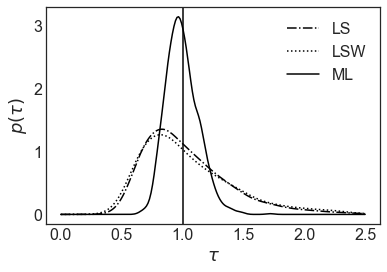

In [9]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/Users/hstrey/miniconda3/envs/pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


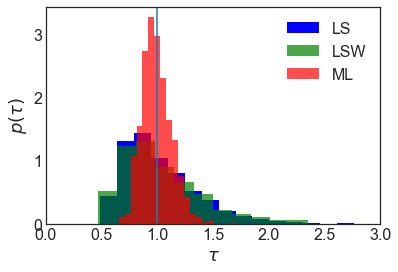

In [10]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[6],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [11]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[9]
thetaW = 1/result_array.T[7]
omegaW = 1/result_array.T[10]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [12]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.016478751794738906
Decay time LS std (fit corrected): 0.01657870257363243
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.01657870257363243
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


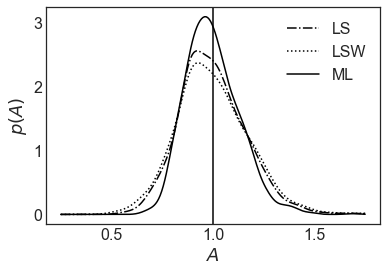

In [13]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

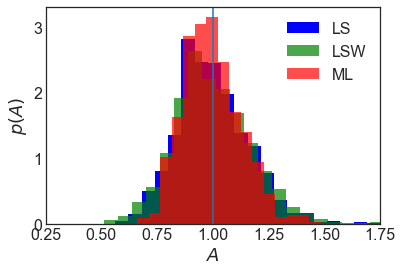

In [14]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[8],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [15]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 0.01145025908410378
Amplitude LS std (fit corrected): 0.0113979437567719
Amplitude LSW mean (real): 4.692624086158618
Amplitude LSW std (real): 8.3673321023892
Amplitude LSW stderr (real): 0.08367332102389201
Amplitude LSW std (fit): 0.9950832668680414
Amplitude LSW std (fit corrected): 0.0113979437567719
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 12)
(1000, 4)
(0.3183106738638477, 5.548446448599749e-25)


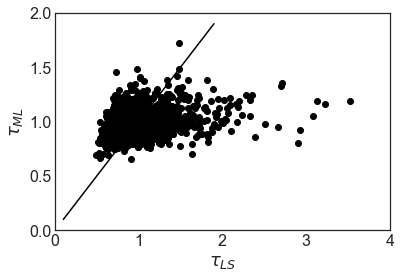

In [16]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114347767423, 1.3727086902427204e-263)


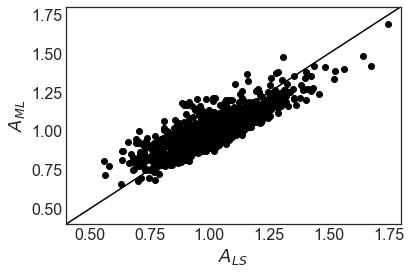

In [17]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696056012 0.00544211158822298 0.9939418654806541 0.009520460345979705
1 0.7384507401780944 0.014800775155431269 1.659481283174133 0.04862577555746138
2 0.8189945390255113 0.008341269650960773 1.2161571144605954 0.017689000724257463
3 1.177426213439023 0.008512380556837134 0.869670623699744 0.008946273247059084
4 1.0437891737470233 0.014007021533873081 0.6674355511975543 0.012763371773673647
5 0.883051617048809 0.00858219052936581 0.7431840677695469 0.010284184173800653
6 0.9986686993248759 0.005205087905933227 0.8289406605407509 0.006148559498558599
7 0.8705609103632095 0.007324202103499727 1.2761723469792459 0.015361640341763991
8 1.0469415961904982 0.004889410637600746 1.0666728821039506 0.0070945098128067305
9 0.8705229773500358 0.005136756260122944 1.404644623697107 0.011921526795272194
10 1.210331143970472 0.021603434174906247 0.6449979054220899 0.01641139632324621
11 1.0678373545348654 0.012159441384276045 1.5898917788383589 0.02633043239929993
12 1.0466327034058365 0.0

654 0.9936219950470155 0.005414179861089583 0.8642170549210936 0.006700783508067425
655 0.9240406108029715 0.00330686558496609 1.045521047963906 0.005327163680617353
656 1.0419611587831445 0.010706304584901134 0.6016159816963211 0.008814440906433869
657 1.3796906367257336 0.02222836263394379 0.701316109097676 0.01609135223724567
658 1.0016502579041822 0.0196156387040846 0.6052074257861851 0.01690327110643452
659 0.8068790536838826 0.01054494900882596 1.209396393375598 0.02256727351677917
660 0.8448943450381698 0.008104959206695895 0.5985731767133358 0.00818731340133432
661 1.425040936832656 0.017156454556700167 0.8211897195886859 0.0140687801472775
662 0.9792009851114964 0.011699141806397096 0.6683429612381256 0.011377033103454235
663 1.1043645708874874 0.010658960854813097 0.815656013010224 0.011202964241582554
664 1.0718439886361044 0.01633558504317089 0.8307712651697817 0.018019844322990988
665 1.0101628959444144 0.009785476078363185 1.1163078044779504 0.015409466846674937
666 0.944

In [62]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))
print(acf.shape)

0.00E+00
-79527971.70080663
0.3989422804014327
2.59E-01
-0.18841818509930627
(500,)


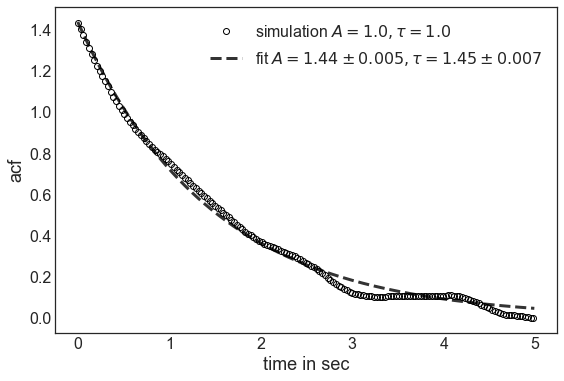

In [64]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,"k--",linewidth=3,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [21]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [22]:
# plot deviation from true D as function of N
Nsim = np.array([2000,10000,50000])
Nsimfit = np.array([1500,10000,60000])
dD = np.array([0.36,0.05,0.014])

(0.005, 1)

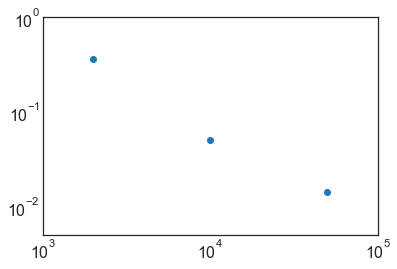

In [23]:
plt.plot(Nsim,dD,"o")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))

In [24]:
lnNsim = np.log(Nsim)
lndD = np.log(dD)

In [25]:
p = np.polyfit(lnNsim,lndD,1)

In [26]:
# dD = A*Nsim**gamma
# ln dD = ln A + gamma*ln Nsim
dDfit = np.exp(p[1])*Nsimfit**p[0]

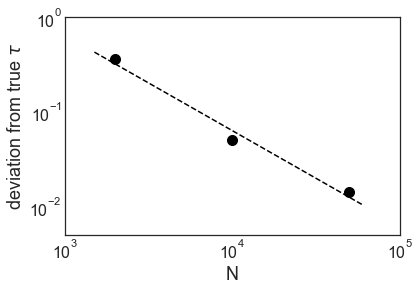

In [27]:
plt.plot(Nsim,dD,"ko",markersize=10)
plt.plot(Nsimfit,dDfit,"k--")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))
plt.xlabel("N")
plt.ylabel(r"deviation from true $\tau$")
plt.savefig("deviation.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [87]:
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=1000)
    tau = pm.Uniform('tau', lower=0, upper=1000)

    likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=1/acf_std**2,observed=acf_all[0])
    
    trace = pm.sample(20000,tune=10000)
    
pm.traceplot(trace)
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains:   1%|▏         | 812/60000 [00:03<04:12, 234.34draws/s] 


RuntimeError: Chain 0 failed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2e4596a0>,
      dtype=object)

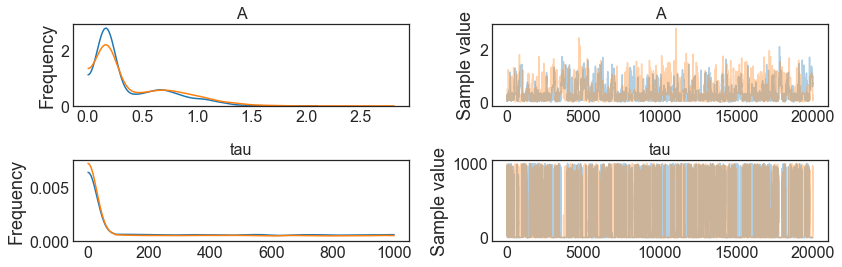

In [84]:
pm.traceplot(trace)

In [85]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,0.401715,0.340696,0.014907,0.017399,1.093324,469.620652,1.006311
tau,283.447854,327.373345,9.520262,0.004183,912.255553,973.172132,1.002381


[1.11432556 1.25665654 1.30799944 1.41670607 1.53124401 1.58929207
 1.7610644 ]
[1.07433766 1.26142057 1.32794904 1.48416813 1.66121954 1.75775482
 2.07731609]
A_sigma 0.16631776545153554
tau_sigma 0.24816712069774882


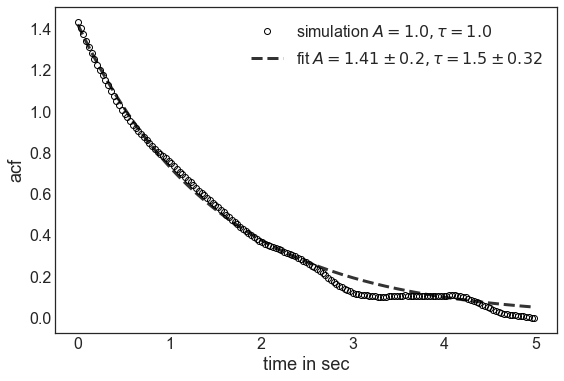

In [70]:
A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
print(A_perc)
print(tau_perc)
print('A_sigma',(A_perc[5]-A_perc[1])/2)
print('tau_sigma',(tau_perc[5]-tau_perc[1])/2)
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t[::3],trace['A'].mean()*np.exp(-t[::3]/trace['tau'].mean()),"k--",linewidth=3,label=r"fit $A=1.41\pm0.2,\tau=1.5\pm0.32$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
#plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

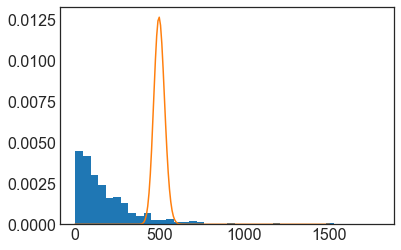

In [44]:
# lets look at the chi^2 distribution of the least-square fit
x=np.linspace(0,1500,200)
chi2dist = chi2.pdf(x,500-2)
plt.hist(result_array.T[11],bins=40,density=True)
plt.plot(x,chi2dist)

In [39]:
result_array.T[11].mean()

192.78086697829272

In [73]:
# use mcmc for all fits
mcmc_results = None

for i,y in enumerate(acf_all):
    with pm.Model() as model:
        A = pm.Uniform('A', lower=0, upper=1000)
        tau = pm.Uniform('tau', lower=0, upper=1000)

        likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=0.5,observed=y)
    
        trace = pm.sample(20000,tune=10000)
    A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
    tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
    A_sigma = (A_perc[5]-A_perc[1])/2
    tau_sigma = (tau_perc[5]-tau_perc[1])/2
    A_med = A_perc[3]
    tau_med = tau_perc[3]
    if mcmc_results is None:
        mcmc_results = np.array([A_med,tau_med,A_sigma,tau_sigma])
    else:
        mcmc_results = np.vstack((mcmc_results,np.array([A_med,tau_med,A_sigma,tau_sigma])))




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:45<00:00, 1310.69draws/s]
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6866089704693292, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1682 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6197471715152444, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:44<00:00, 1361.58draws/s]
There were 147 divergences a

NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [01:38<00:00, 201.62draws/s]
The acceptance probability does not match the target. It is 0.9695933548439422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.952481328885226, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [01:44<00:00, 574.53draws/s]
The acceptance probability does not match the target. It is 0.9199070069414181, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4491907732169495, but s

The acceptance probability does not match the target. It is 0.956974032874886, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [01:38<00:00, 606.97draws/s] 
There were 2291 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23471082037498542, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9814405851032474, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2

Sampling 2 chains: 100%|██████████| 60000/60000 [00:51<00:00, 1169.01draws/s]
The acceptance probability does not match the target. It is 0.9347156121203729, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9057011508815839, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:46<00:00, 1296.77draws/s]
The acceptance probability does not match the target. It is 0.8817534370010085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7121095808888894, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler..

There were 935 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:50<00:00, 1180.83draws/s]
The acceptance probability does not match the target. It is 0.9740570144824897, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9218653156672802, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1429.32draws/s]
There were 795 divergences after tuning. 

Sampling 2 chains: 100%|██████████| 60000/60000 [00:40<00:00, 1473.03draws/s]
There were 3489 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5321052371195008, but should be close to 0.8. Try to increase the number of tuning steps.
There were 647 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6929410860059689, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:42<00:00, 1414.74draws/s]
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.706847436565806

The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1444.76draws/s]
There were 4312 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.38292678232201877, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1218 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4944475324539686, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:43<00:00, 1387.93draws/s]
There were 1153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6681269265326734, but should be close to 0.8. Try to increase the number of tuning steps.
There were 833 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6194226425206294, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1638.40draws/s]
The acceptance probability d

NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1662.21draws/s]
There were 1251 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18494049867148105, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1655.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:49<00:00, 1219.43draws/s]
The acceptance probability does not match the target. It is 0.9148561793418034, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4206 div

Sampling 2 chains: 100%|██████████| 60000/60000 [00:56<00:00, 559.35draws/s] 
The acceptance probability does not match the target. It is 0.9665605758054308, but should be close to 0.8. Try to increase the number of tuning steps.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.501844692503024, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1443.64draws/s]
The acceptance probability does not match the target. It is 0.9079485414250934, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS samp

RuntimeError: Chain 1 failed.

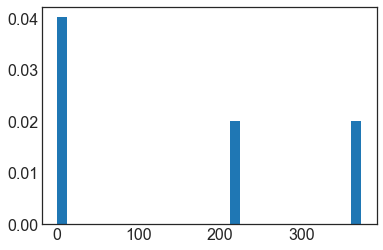

In [78]:
_=plt.hist(mcmc_results[2],bins=30,density=True)